# This code was Inspired by https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/?utm_content=cmp-true#google_vignette

# Necessary Libraries

In [522]:
import matplotlib.pyplot as plt
import nltk #Ensure downloading NLTK
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import contractions
from pprint import pprint 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Pre-processing

In [523]:
# Load the dataset
file_path = 'nykaa_filtered_lip_products.csv'
df = pd.read_csv(file_path)
processed_docs = df['review_text']

In [433]:
processed_docs[10]

'This product moisturises lips really well, also has a great scent. Best lip balm I’ve used so far.'

In [434]:
text = str(processed_docs[10])
text

'This product moisturises lips really well, also has a great scent. Best lip balm I’ve used so far.'

In [435]:
text = contractions.fix(text)
text

'This product moisturises lips really well, also has a great scent. Best lip balm I have used so far.'

In [436]:
text = text.lower()
text

'this product moisturises lips really well, also has a great scent. best lip balm i have used so far.'

In [437]:
tokens = word_tokenize(text)
tokens

['this',
 'product',
 'moisturises',
 'lips',
 'really',
 'well',
 ',',
 'also',
 'has',
 'a',
 'great',
 'scent',
 '.',
 'best',
 'lip',
 'balm',
 'i',
 'have',
 'used',
 'so',
 'far',
 '.']

In [438]:
tokens = [re.sub(r'[^a-zA-Z\s]', '', token) for token in tokens]
tokens

['this',
 'product',
 'moisturises',
 'lips',
 'really',
 'well',
 '',
 'also',
 'has',
 'a',
 'great',
 'scent',
 '',
 'best',
 'lip',
 'balm',
 'i',
 'have',
 'used',
 'so',
 'far',
 '']

In [510]:
stop_words = set(stopwords.words('english'))
stop_words.update(['nykaa', 'lip', 'lips','lipstick', 'eye', 'shadow', 'eyeshadow', 'good'])
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token != '']
tokens

['product',
 'moisturises',
 'really',
 'well',
 'also',
 'great',
 'scent',
 'best',
 'balm',
 'used',
 'far']

In [524]:
def data_preprocessing(text):
    text = str(text)
    text = contractions.fix(text)  # Expand contractions here
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [re.sub(r'[^a-zA-Z\s]', '', token) for token in tokens]  # Remove special characters and digits from each token
    stop_words = set(stopwords.words('english'))
    stop_words.update(['nykaa', 'lip', 'lips','lipstick', 'eye', 'shadow', 'eyeshadow', 'good'])
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token != '']  # Lemmatize & remove stopwords
    return tokens

In [525]:
processed_docs = df['review_text'].map(data_preprocessing)
processed_docs

0                           [loved, perfect, dusky, skin]
1       [blueberry, lipbalm, milk, fragrance, work, well]
2       [liked, moisturize, like, smell, initially, ha...
3                           [light, apply, n, nourishing]
4       [love, balmit, moisturizes, well, also, smell,...
                              ...                        
4647    [bt, think, like, nyk, bt, pigmented, totally,...
4648    [small, size, le, countity, west, money, iam, ...
4649    [small, one, time, use, dried, product, total,...
4650    [worth, firstly, comparison, price, charged, c...
4651               [small, quantity, also, le, satisfied]
Name: review_text, Length: 4652, dtype: object

# WordCloud

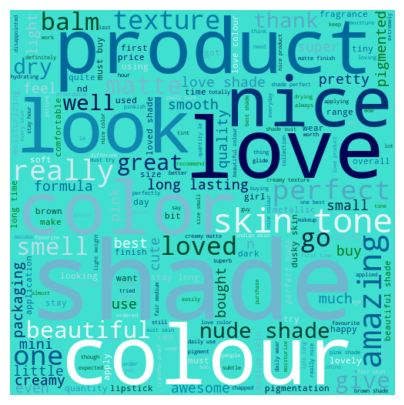

In [526]:
# Combine all processed documents into a single string
words_in_reviews = " ".join([" ".join(doc) for doc in processed_docs])

# Plotting the word cloud
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(width=500, height=500, background_color='#40E0D0', colormap="ocean", random_state=10).generate(words_in_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [527]:
def lda_experiments(dictionary, corpus, texts, start=3, limit=20, step=1):
    coherence_values = []
    model_list = []
    topic_numbers = range(start, limit + 1, step)

    for num_topics in topic_numbers:
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                         iterations=400, passes=10, random_state=42, per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        print(f"Completed LDA with {num_topics} topics. Coherence score: {coherencemodel.get_coherence()}")

    # Find the model with the highest coherence score
    best_coherence = max(coherence_values)
    best_model_index = coherence_values.index(best_coherence)
    best_model = model_list[best_model_index]

    # Plotting
    plt.figure(figsize=(5, 5))
    plt.plot(topic_numbers, coherence_values, marker='o')
    plt.title('LDA Coherence Score by Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(topic_numbers)
    plt.grid(True)
    plt.show()

    return best_model, best_coherence

# LDA Topic Modeling unigrams only

In [528]:
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [476]:
target_word = 'shade'

# Get the word ID for the target word
target_id = dictionary.token2id.get(target_word)

# Initialize the counter for occurrences
unigram_count = 0

# Count the occurrences of the target word across the corpus
if target_id is not None:
    for doc in corpus:
        for word_id, count in doc:
            if word_id == target_id:
                unigram_count += count

print(f'Total occurrences of the unigram "{target_word}": {unigram_count}')

Total occurrences of the unigram "shade": 1939


Completed LDA with 3 topics. Coherence score: 0.42427971754583854
Completed LDA with 4 topics. Coherence score: 0.4200725103140213
Completed LDA with 5 topics. Coherence score: 0.4360164377992949
Completed LDA with 6 topics. Coherence score: 0.443126593591682
Completed LDA with 7 topics. Coherence score: 0.41564759653122774
Completed LDA with 8 topics. Coherence score: 0.4318335656519975
Completed LDA with 9 topics. Coherence score: 0.4312066274878351
Completed LDA with 10 topics. Coherence score: 0.40628377460702636
Completed LDA with 11 topics. Coherence score: 0.4050069606262522
Completed LDA with 12 topics. Coherence score: 0.39053666020347877
Completed LDA with 13 topics. Coherence score: 0.40743117623109476
Completed LDA with 14 topics. Coherence score: 0.39877651379137463
Completed LDA with 15 topics. Coherence score: 0.39917465732756696
Completed LDA with 16 topics. Coherence score: 0.40132915435240646
Completed LDA with 17 topics. Coherence score: 0.36559649394402766
Completed

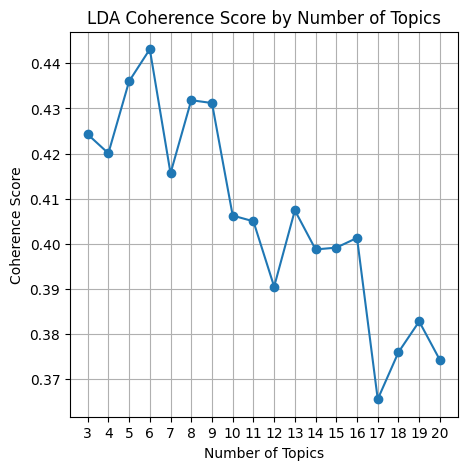

In [514]:
model, coherence = lda_experiments(dictionary=dictionary, corpus=corpus, texts=processed_docs, start=3, limit=20, step=1)

In [478]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model, corpus, dictionary)

# Display the visualization in a Jupyter Notebook
pyLDAvis.display(vis)

In [479]:
from pprint import pprint 

topics = model.print_topics()
for topic in topics:
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.038*"shade" + 0.018*"one" + 0.015*"buy" + 0.015*"go" + 0.012*"mini" + 0.011*"daily" + 0.011*"even" + 0.010*"hour" + 0.010*"use" + 0.009*"wear"
Topic 1: 0.063*"product" + 0.061*"small" + 0.042*"size" + 0.030*"quantity" + 0.028*"price" + 0.027*"nice" + 0.022*"quality" + 0.020*"colour" + 0.020*"le" + 0.015*"color"
Topic 2: 0.044*"look" + 0.041*"shade" + 0.033*"colour" + 0.021*"give" + 0.021*"texture" + 0.021*"matte" + 0.016*"color" + 0.015*"love" + 0.015*"perfect" + 0.015*"nude"
Topic 3: 0.051*"skin" + 0.039*"long" + 0.039*"tone" + 0.038*"color" + 0.027*"stay" + 0.025*"colour" + 0.023*"shade" + 0.019*"lasting" + 0.019*"suit" + 0.016*"medium"
Topic 4: 0.025*"metallic" + 0.023*"balm" + 0.021*"love" + 0.020*"smell" + 0.020*"like" + 0.020*"product" + 0.019*"really" + 0.018*"amazing" + 0.018*"dry" + 0.014*"one"
Topic 5: 0.118*"shade" + 0.043*"love" + 0.031*"perfect" + 0.031*"beautiful" + 0.026*"look" + 0.022*"loved" + 0.018*"nude" + 0.016*"skin" + 0.015*"pink" + 0.014*"colour"


In [538]:
dominant_topics = []

for doc_bow in corpus:
    topic_probabilities = model[doc_bow]
    dominant_topic = max(topic_probabilities, key=lambda x: x[1])[0]  # get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Now `dominant_topics` contains the dominant topic index for each document
# map the topic index to more meaningful labels:
topic_labels = {0: "Product Quality", 1: "Size and Quantity", 2: "Texture", 3: "Skin Tone", 4: "Product Quality", 5: "Shade"}  # Map topic indices to labels
labeled_topics = [topic_labels[topic] for topic in dominant_topics]

labeled_topics

df['Dominant_Topic_Label'] = labeled_topics

df.head(50)
df.to_csv('nykaa_labeled.csv', index=False)

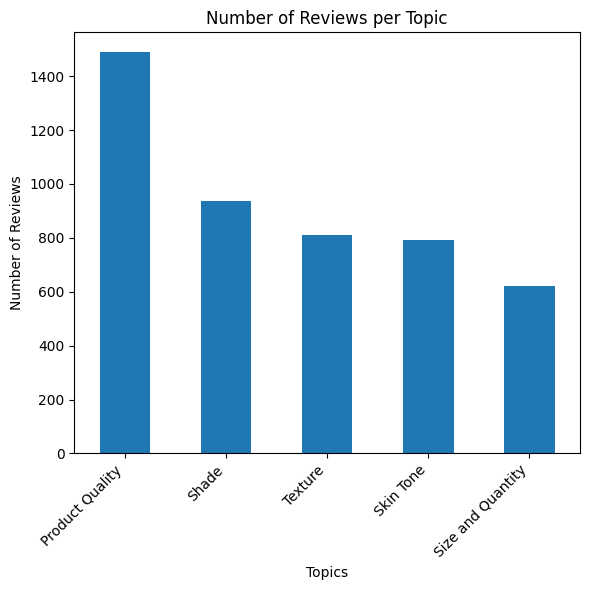

In [539]:
# Count the occurrences of each topic
topic_counts = pd.Series(labeled_topics).value_counts()

# Plotting
plt.figure(figsize=(6, 6))
topic_counts.plot(kind='bar')
plt.title('Number of Reviews per Topic')
plt.xlabel('Topics')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# LDA Topic Modeling using Bi-grams

In [485]:
bigram = Phrases(processed_docs, min_count=3, threshold=10)
bigram_mod = Phraser(bigram)

# Apply bi-gram model
docs_bigrams = [bigram_mod[doc] for doc in processed_docs]

# Proceed with these documents to create  dictionary and corpus
dictionary_bigrams = Dictionary(docs_bigrams)
corpus_bigrams = [dictionary_bigrams.doc2bow(doc) for doc in docs_bigrams]

In [492]:
# See bigram example
print([bigram_mod[processed_docs[19]]])

[['soft', 'balm', 'glide', 'like_butter', 'hydrate', 'perfectly', 'stay', 'power', 'le', 'okay']]


In [493]:
print(corpus_bigrams[19:20])

[[(40, 1), (45, 1), (78, 1), (103, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)]]


In [494]:
[[(dictionary_bigrams[id], freq) for id, freq in cp] for cp in corpus_bigrams[19:20]]

[[('balm', 1),
  ('stay', 1),
  ('soft', 1),
  ('hydrate', 1),
  ('glide', 1),
  ('le', 1),
  ('like_butter', 1),
  ('okay', 1),
  ('perfectly', 1),
  ('power', 1)]]

Completed LDA with 3 topics. Coherence score: 0.381547855106566
Completed LDA with 4 topics. Coherence score: 0.4011541967755644
Completed LDA with 5 topics. Coherence score: 0.36264837460761756
Completed LDA with 6 topics. Coherence score: 0.35776021885285153
Completed LDA with 7 topics. Coherence score: 0.36862582038572
Completed LDA with 8 topics. Coherence score: 0.3661397134870603
Completed LDA with 9 topics. Coherence score: 0.3671693730297138
Completed LDA with 10 topics. Coherence score: 0.36849628986864735
Completed LDA with 11 topics. Coherence score: 0.37684718249797
Completed LDA with 12 topics. Coherence score: 0.3552100711443351
Completed LDA with 13 topics. Coherence score: 0.3548206976940096
Completed LDA with 14 topics. Coherence score: 0.34833992368291977
Completed LDA with 15 topics. Coherence score: 0.3480765133667978
Completed LDA with 16 topics. Coherence score: 0.3513683937547643
Completed LDA with 17 topics. Coherence score: 0.372995910226731
Completed LDA with 

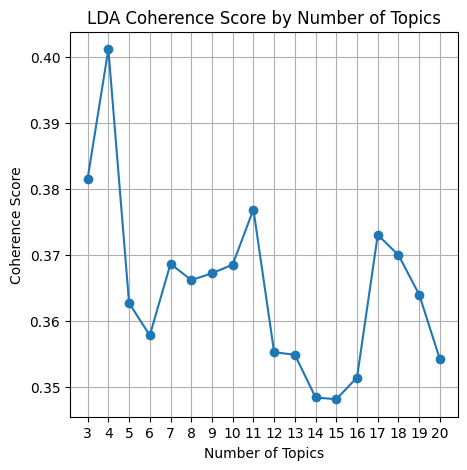

In [518]:
bigrams_model, bigrams_coherence = lda_experiments(dictionary=dictionary_bigrams, corpus=corpus_bigrams, texts=docs_bigrams, start=3, limit=20, step=1)

In [520]:
topics = bigrams_model.print_topics()
for topic in topics:
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.054*"shade" + 0.033*"look" + 0.020*"colour" + 0.017*"love" + 0.015*"perfect" + 0.012*"metallic" + 0.011*"like" + 0.009*"pink" + 0.009*"beautiful" + 0.009*"red"
Topic 1: 0.032*"small" + 0.032*"product" + 0.018*"size" + 0.018*"colour" + 0.015*"price" + 0.015*"shade" + 0.014*"one" + 0.014*"tiny" + 0.013*"quantity" + 0.013*"mini"
Topic 2: 0.072*"shade" + 0.027*"nude" + 0.019*"perfect" + 0.017*"best" + 0.017*"love" + 0.016*"look" + 0.016*"tone" + 0.016*"beautiful" + 0.014*"skin_tone" + 0.014*"color"
Topic 3: 0.043*"love" + 0.043*"nice" + 0.040*"product" + 0.035*"color" + 0.030*"colour" + 0.026*"texture" + 0.022*"really" + 0.019*"amazing" + 0.018*"long_lasting" + 0.017*"smooth"


In [497]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# Ensure you have the latest versions of pyLDAvis and gensim to avoid compatibility issues

# Prepare the visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(bigrams_model, corpus_bigrams, dictionary_bigrams)

# Display the visualization in a Jupyter Notebook
pyLDAvis.display(vis)

# LDA Topic Modeling using Tri-grams

In [529]:
bigram = Phrases(processed_docs, min_count=3, threshold=10)
trigram = Phrases(bigram[processed_docs], min_count=3 ,threshold=10)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Apply tri-gram model
docs_trigrams = [trigram_mod[bigram_mod[doc]] for doc in processed_docs]

# Proceed with these documents to create  dictionary and corpus
dictionary_trigrams = Dictionary(docs_trigrams)
corpus_trigrams = [dictionary_trigrams.doc2bow(doc) for doc in docs_trigrams]

In [530]:
print(trigram_mod[bigram_mod[processed_docs[19]]])

['soft', 'balm', 'glide_like_butter', 'hydrate', 'perfectly', 'stay_power', 'le', 'okay']


Completed LDA with 3 topics. Coherence score: 0.38232160344536953
Completed LDA with 4 topics. Coherence score: 0.34499685246868383
Completed LDA with 5 topics. Coherence score: 0.37878220535766005
Completed LDA with 6 topics. Coherence score: 0.3488606809259356
Completed LDA with 7 topics. Coherence score: 0.34761948498045053
Completed LDA with 8 topics. Coherence score: 0.33453010847604225
Completed LDA with 9 topics. Coherence score: 0.3584972596294066
Completed LDA with 10 topics. Coherence score: 0.3457351632227832
Completed LDA with 11 topics. Coherence score: 0.3535817374647165
Completed LDA with 12 topics. Coherence score: 0.3491520348779334
Completed LDA with 13 topics. Coherence score: 0.3369037697320828
Completed LDA with 14 topics. Coherence score: 0.3462193012895211
Completed LDA with 15 topics. Coherence score: 0.34105316069772307
Completed LDA with 16 topics. Coherence score: 0.35231412938946816
Completed LDA with 17 topics. Coherence score: 0.34828325602564847
Completed

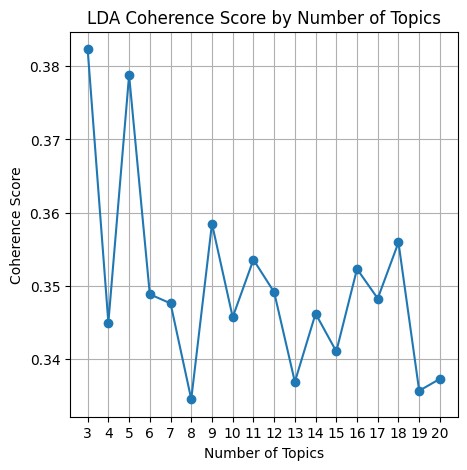

In [531]:
trigrams_model, trigrams_coherence = lda_experiments(dictionary=dictionary_trigrams, corpus=corpus_trigrams, texts=docs_trigrams, start=3, limit=20, step=1)

In [532]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# Ensure you have the latest versions of pyLDAvis and gensim to avoid compatibility issues

# Prepare the visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(trigrams_model, corpus_trigrams, dictionary_trigrams)

# Display the visualization in a Jupyter Notebook
pyLDAvis.display(vis)